In [1]:
import sys
!{sys.executable} -m pip install pandas 
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install geopandas 
%matplotlib inline

import pandas as pd
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import geopandas

## Data Preparation
Read data from `Chicago_Population_Counts.csv` as a dataframe
1. Filter only 2019 data and filter out citywide data entry
2. Transform zip codes from str type to int type
3. Transform age, gender and race data from number of population to percentages

In [2]:
## read data from csv file, filter and tranform zip code data type
population_df = pd.read_csv('Chicago_Population_Counts.csv')
population_df = population_df[(population_df['Year'] == 2019) & (population_df['Geography Type'] == 'Zip Code')]
population_df.Geography = population_df.Geography.apply(lambda x: int(x))
population_df.shape

(58, 25)

Here we can see that the population count data collected from Chicago Data Portal has gender, age, and race population data in 58 zip code regions, but there exist some mismatches in Chicago zip codes between population dataset and yelp dataset. For analyses within same dataset, I do not modify based on mutually existing zip codes; but for analyses involving both datasets, I keep zip codes that exist in the population dataset.  

In [3]:
## transform age, gender, and race population data into percentage
population_df = population_df.apply(lambda x: x if x.name in ['Geography Type', 'Year', 'Geography', 'Population - Total', 'Record ID'] else (np.array(x).astype(float)/np.array(population_df['Population - Total'])*100))
population_df.head()

,Geography Type,Year,Geography,Population - Total,Population - Age 0-17,Population - Age 18-29,Population - Age 30-39,Population - Age 40-49,Population - Age 50-59,Population - Age 60-69,...,Population - Age 18+,Population - Age 65+,Population - Female,Population - Male,Population - Latinx,Population - Asian Non-Latinx,Population - Black Non-Latinx,Population - White Non-Latinx,Population - Other Race Non-Latinx,Record ID
61,Zip Code,2019,60601,15083,5.834383,34.522310,18.537426,13.856660,6.431081,11.489757,...,94.165617,13.982629,53.397865,46.602135,8.115096,18.955115,4.229928,65.895379,2.804482,ZIP_Code-60601-2019
62,Zip Code,2019,60602,1145,13.013100,18.078603,46.026201,15.720524,5.764192,1.397380,...,86.986900,0.524017,44.192140,55.807860,6.462882,21.397380,4.279476,59.388646,8.471616,ZIP_Code-60602-2019
63,Zip Code,2019,60603,1052,1.520913,47.338403,12.452471,7.224335,16.539924,8.079848,...,98.479087,11.406844,50.285171,49.714829,3.231939,32.034221,3.231939,60.836502,0.665399,ZIP_Code-60603-2019
64,Zip Code,2019,60604,823,4.374241,39.489672,19.319563,6.682868,11.057108,12.515188,...,95.625759,8.748481,52.369380,47.630620,3.402187,29.161604,4.981774,62.454435,0.000000,ZIP_Code-60604-2019
65,Zip Code,2019,60605,29060,8.296628,29.315210,25.017206,12.460427,10.942877,7.450103,...,91.703372,10.058500,54.810736,45.189264,7.518926,15.061941,14.693737,58.035100,4.690296,ZIP_Code-60605-2019


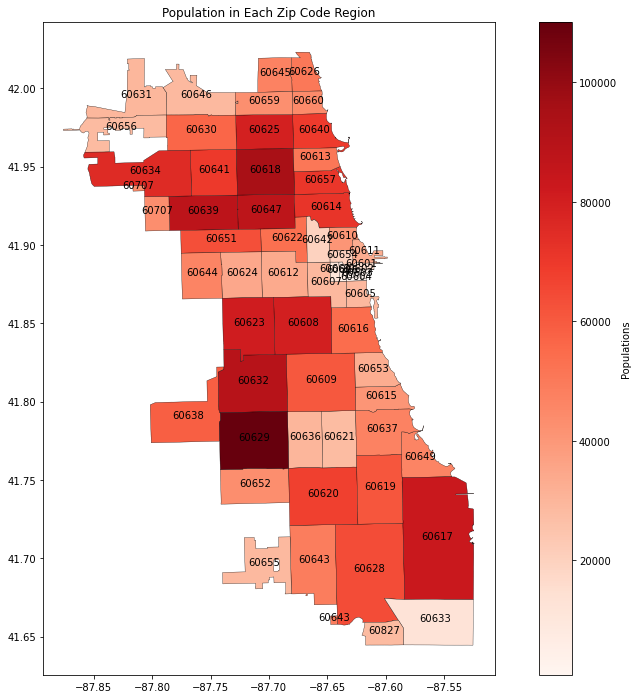

In [4]:
chi_zip_codes = geopandas.read_file('geo_export_1534664d-7f36-464a-b110-f56e1eee2bcf.dbf')
chi_zip_codes['zip'] = chi_zip_codes['zip'].astype(int)
chi_zip_codes_pop = pd.merge(chi_zip_codes, population_df, left_on=['zip'], right_on=['Geography'], how='left')
fig, ax = plt.subplots(figsize=(16,12))
chi_zip_codes_pop.plot(ax=ax, column='Population - Total', edgecolor='black', linewidth=.3, cmap='Reds', legend=True, legend_kwds={'label': 'Populations'})
ax.set_title('Population in Each Zip Code Region')
for _, row in chi_zip_codes_pop.iterrows():
    xy = row['geometry'].centroid.coords
    ax.annotate(row['zip'], xy=xy[0],
                 horizontalalignment='center',
                 color='black')


Read data from `yelp_data_file.csv`, organize, and convert to a pandas dataframe
1. Price is not contained in the header and all data entries, which makes some data entries not aligned with the header. Here, I reorganize the price data and insert NaN for those having no price data. I also transform price data into integers. 
2. Transform rating and review count data type into float and int. 
3. Parse zip code of each bubble tea shop from location.

In [5]:
yelp_data = []
header = ""
price_idx = 0
with open('yelp_data_file.csv') as csvfile:
    data_reader = csv.reader(csvfile)
    for row in data_reader:
        if not header:
            header = row
            price_idx = header.index('price')
        else:
            if row[price_idx][0] != '$': #price data present
                row.insert(price_idx, np.nan)
            else:
                row[price_idx] = len(row[price_idx]) #$ = 1, $$ = 2...
                # scale: “$” = under $10; “$$” = “$11-$30”; “$$$” = “$31-$60”; “$$$$” = “above $61”
            yelp_data.append(row)



In [6]:
## transform yelp_data to dataframe
yelp_df = pd.DataFrame(yelp_data, columns=header)
print(yelp_df.shape)
yelp_df.head()

(980, 16)


,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
0,SfPpG-v8K-t6tAr4USL-mw,vivi-bubble-tea-chicago,Vivi Bubble Tea,https://s3-media4.fl.yelpcdn.com/bphoto/RjoWTq...,False,https://www.yelp.com/biz/vivi-bubble-tea-chica...,299,"[{'alias': 'bubbletea', 'title': 'Bubble Tea'}]",4.0,"{'latitude': 41.877308, 'longitude': -87.627432}","['pickup', 'delivery']",1.0,"{'address1': '333 S State St', 'address2': '',...",+13124311150,(312) 431-1150,906.5408434347613
1,ATlXGZTMhSheo_9zB3hfbQ,teamo-boba-bar-chicago-4,Te'amo Boba Bar,https://s3-media2.fl.yelpcdn.com/bphoto/hFNx3r...,False,https://www.yelp.com/biz/teamo-boba-bar-chicag...,155,"[{'alias': 'bubbletea', 'title': 'Bubble Tea'}...",4.0,"{'latitude': 41.891528, 'longitude': -87.624885}","['pickup', 'delivery']",2.0,"{'address1': '520 N Michigan Ave', 'address2':...",+13127779125,(312) 777-9125,746.950085209939
2,7h3NRC53zt4llWs7Jag7sg,mycha-chicago-2,Mycha,https://s3-media2.fl.yelpcdn.com/bphoto/2kJNGF...,False,https://www.yelp.com/biz/mycha-chicago-2?adjus...,18,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",4.5,"{'latitude': 41.8834734, 'longitude': -87.6282...",['delivery'],NaN,"{'address1': '108 N State St', 'address2': 'Bl...",+18472608387,(847) 260-8387,425.99012323039926
3,R9jRdYgRsS1oDQdP-DICxA,panda-express-chicago-26,Panda Express,https://s3-media1.fl.yelpcdn.com/bphoto/3XQBVY...,False,https://www.yelp.com/biz/panda-express-chicago...,40,"[{'alias': 'chinese', 'title': 'Chinese'}, {'a...",3.0,"{'latitude': 41.8856035299199, 'longitude': -8...","['pickup', 'delivery']",1.0,"{'address1': '180 N. Wabash Suite 184', 'addr...",+13124191543,(312) 419-1543,274.11493330272003
4,HOKtJ2vkBwM9rjzslC_Eng,bubblelicious-chicago,Bubblelicious,https://s3-media2.fl.yelpcdn.com/bphoto/xoSNpd...,False,https://www.yelp.com/biz/bubblelicious-chicago...,1,"[{'alias': 'bubbletea', 'title': 'Bubble Tea'}]",5.0,"{'latitude': 41.88539, 'longitude': -87.62414}",[],NaN,"{'address1': '179 Michigan Ave', 'address2': '...",+13127295359,(312) 729-5359,82.08266991166217


Here we can see that there are 980 data entries from the yelp dataset, each of them has its own data about reviews, ratings, location, and price. 

In [7]:
## aggregate bubble tea shops data by zip code region
def parse_zipcode(location_str):
    location = location_str.strip('{').strip('}').split(',')[-1][-7:-2]
    return int(location)

yelp_df['rating'] = yelp_df['rating'].astype(float)
yelp_df['review_count'] = yelp_df['review_count'].astype(int)
yelp_df['zipcode'] = yelp_df['location'].apply(lambda x: parse_zipcode(x))

aggregation_by_region = yelp_df\
    .groupby('zipcode')\
    .agg({
        'id': 'count',
        'rating': 'mean',
        'review_count': 'mean',
        'price': 'mean'
    })\
    .rename(columns={'id': 'counts'})\
    .reset_index()\
    .sort_values('counts', ascending=False)
aggregation_by_region

,zipcode,counts,rating,review_count,price
30,60616,228,4.184211,130.710526,1.569620
24,60607,108,4.189815,104.490741,1.661538
35,60640,60,3.900000,90.800000,1.333333
20,60601,48,3.958333,21.312500,1.000000
23,60605,41,3.939024,144.121951,2.000000
28,60614,38,4.394737,64.815789,1.000000
31,60618,32,4.656250,61.250000,2.000000
32,60622,32,4.000000,15.500000,2.000000
39,60657,27,4.092593,75.444444,1.000000
26,60611,26,3.653846,123.846154,2.000000


## Data Analysis
#### Questions:
1. How many bubble tea shops in each zip code region in Chicago?
2. What are the average rating, review counts, and price for bubble tea shops in each region?

After cleaning population dataset and aggregating yelp dataset, I join them together based on zip codes in the population dataset, and here I get 23 zip code regions that have bubble tea shops data on Yelp. To make the joined dataframe easy to use in the following analysis, I drop three columns that have identical or repetitive values in the dataframe: Geography type, Year, Geography, and Record ID.

In [8]:
df = pd.merge(aggregation_by_region, population_df, how='inner', left_on='zipcode', right_on='Geography')
df = df.drop(columns=['Geography Type', 'Year', 'Geography', 'Record ID'])
df

,zipcode,counts,rating,review_count,price,Population - Total,Population - Age 0-17,Population - Age 18-29,Population - Age 30-39,Population - Age 40-49,...,Population - Age 5+,Population - Age 18+,Population - Age 65+,Population - Female,Population - Male,Population - Latinx,Population - Asian Non-Latinx,Population - Black Non-Latinx,Population - White Non-Latinx,Population - Other Race Non-Latinx
0,60616,228,4.184211,130.710526,1.569620,54197,14.445449,21.324059,15.930771,13.113272,...,96.134472,85.554551,15.934461,52.379283,47.620717,8.430356,39.446833,23.421961,26.602949,2.097902
1,60607,108,4.189815,104.490741,1.661538,29293,10.722698,38.507493,24.633872,10.606630,...,95.504045,89.277302,5.270884,49.714949,50.285051,7.343051,21.520500,14.228655,53.661284,3.246509
2,60640,60,3.900000,90.800000,1.333333,69363,13.044418,20.213947,21.727722,14.674971,...,95.804680,86.955582,13.435117,47.993887,52.006113,14.088203,10.684371,16.556377,55.918862,2.752188
3,60601,48,3.958333,21.312500,1.000000,15083,5.834383,34.522310,18.537426,13.856660,...,97.175628,94.165617,13.982629,53.397865,46.602135,8.115096,18.955115,4.229928,65.895379,2.804482
4,60605,41,3.939024,144.121951,2.000000,29060,8.296628,29.315210,25.017206,12.460427,...,96.397109,91.703372,10.058500,54.810736,45.189264,7.518926,15.061941,14.693737,58.035100,4.690296
5,60614,38,4.394737,64.815789,1.000000,71954,14.057592,34.164883,20.329655,10.364955,...,94.805014,85.942408,9.351808,49.021597,50.978403,6.167829,7.251855,4.191567,79.379882,3.008867
6,60618,32,4.656250,61.250000,2.000000,94907,21.770786,17.791101,21.407272,15.448808,...,93.001570,78.229214,9.165815,49.702340,50.297660,40.258358,6.065938,2.537221,48.039660,3.098823
7,60622,32,4.000000,15.500000,2.000000,53294,14.418133,26.832289,29.740684,12.556761,...,93.365107,85.581867,6.145157,47.596352,52.403648,22.905017,4.381356,5.910609,64.185462,2.617555
8,60657,27,4.092593,75.444444,1.000000,70958,12.614504,33.412723,24.059303,10.056653,...,94.539023,87.385496,8.035739,49.756194,50.243806,7.588996,6.887173,2.938358,79.769723,2.815750
9,60611,26,3.653846,123.846154,2.000000,33224,5.586323,23.410787,21.574765,8.105586,...,97.095473,94.413677,21.496509,53.322899,46.677101,4.734529,18.528774,2.910547,71.541657,2.284493


Looking at the number of bubble tea shops in each zip code region, we can easily see that there exist gaps among different regions, where 60616 has more than 200 bubble tea shops, and the 60626 has only 6 shops. Note that 60616 is where the Chinatown locates, which can be a reason that contributes to such as large number of bubble tea shops.

<AxesSubplot:title={'center':'Bubble Tea Shops in Region'}, xlabel='Zip Code', ylabel='Number of Shops'>

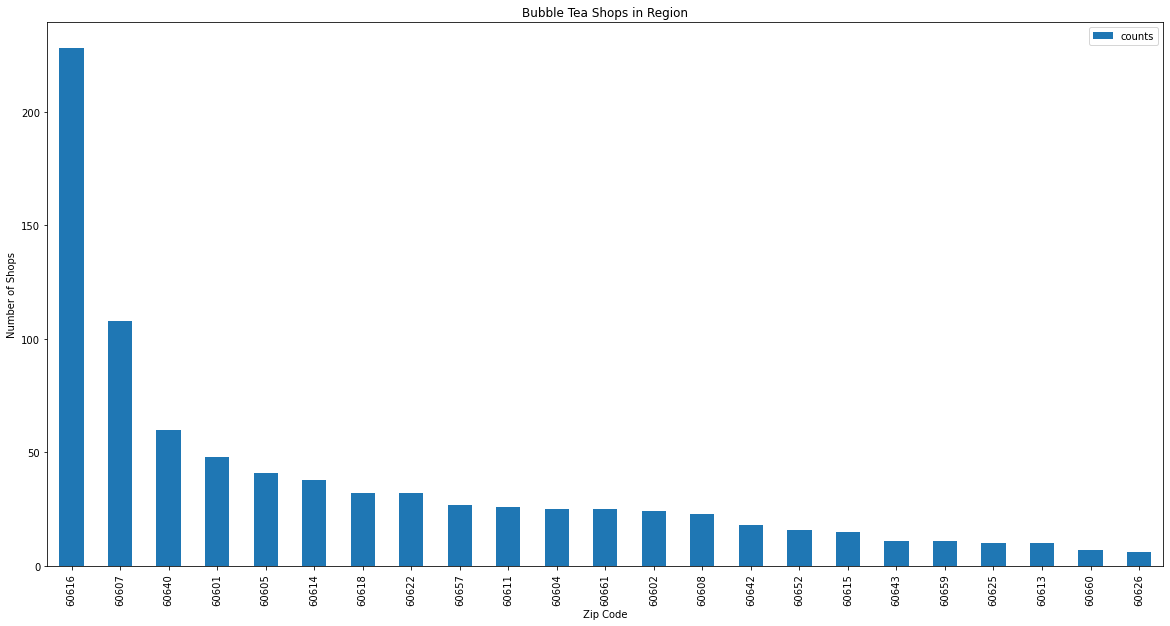

In [9]:
df.plot('zipcode', 'counts', kind='bar', figsize=(20, 10), xlabel='Zip Code', ylabel='Number of Shops', title='Bubble Tea Shops in Region')

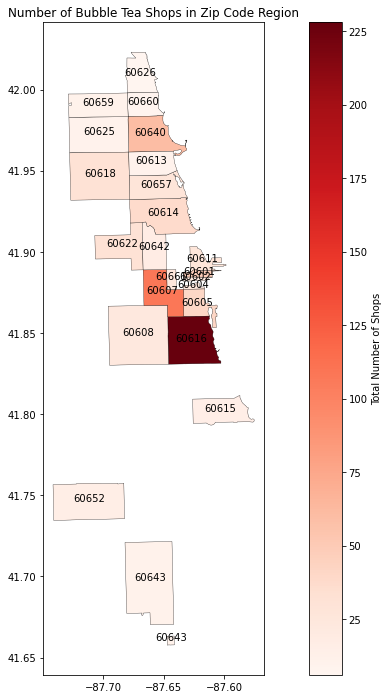

In [10]:
chi_zip_codes = pd.merge(chi_zip_codes, aggregation_by_region, left_on=['zip'], right_on=['zipcode'], how='left')
fig, ax = plt.subplots(figsize=(16,12))
chi_zip_codes.plot(ax=ax, column='counts', edgecolor='black', linewidth=.3, cmap='Reds', legend=True, legend_kwds={'label': 'Total Number of Shops'})
ax.set_title('Number of Bubble Tea Shops in Zip Code Region')
for _, row in chi_zip_codes.iterrows():
    if not np.isnan(row['zipcode']):
        xy = row['geometry'].centroid.coords
        ax.annotate(row['zip'], xy=xy[0],
                    horizontalalignment='center',
                    color='black')

Bubble tea shops in each region have similar ratings, ranging from 2.5 to 5.0, with average rating of 4.06.  

2.5 5.0 4.063861245793559 4.0


<AxesSubplot:title={'center':'Average Rating by Region'}, xlabel='Zip Code', ylabel='Average Rating'>

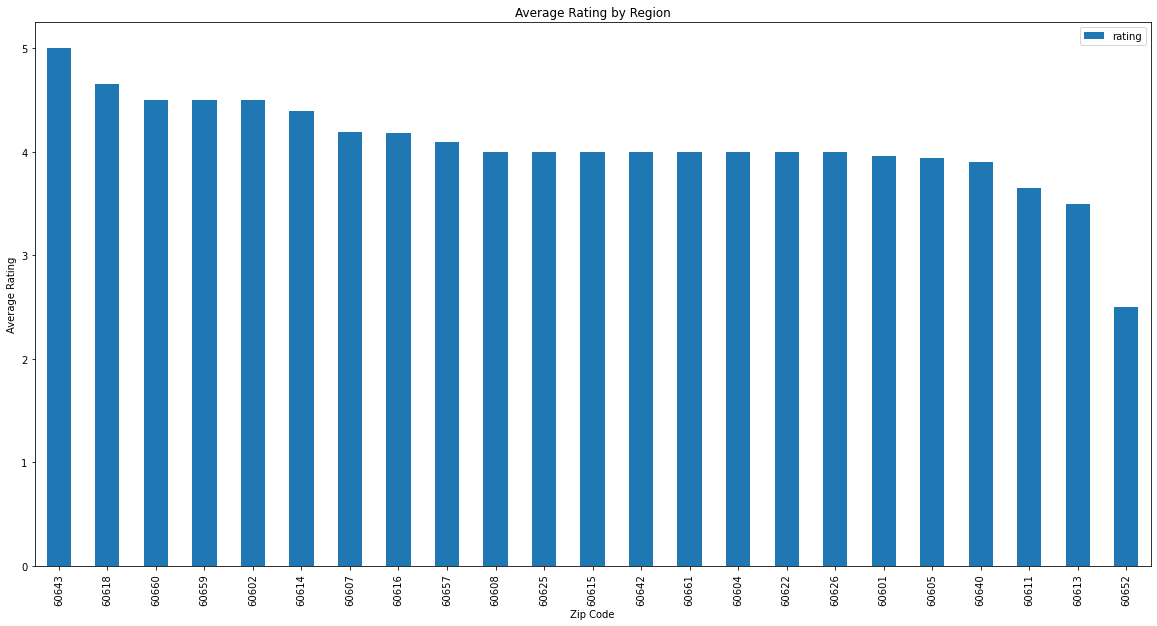

In [11]:
print(min(df.rating), max(df.rating), df.rating.mean(), df.rating.median())
df.sort_values(by='rating', ascending=False).plot('zipcode', 'rating', kind='bar', figsize=(20, 10), xlabel='Zip Code', ylabel='Average Rating', title='Average Rating by Region')

Review count shows a big gap between regions with most and least average reviews. Most regions have less than or about 100 average reviews, but bubble tea shops in 60604 and 60608 are reaching 300 average review counts. 60604 is close to Millennial Park, where a lot of tourists would go to that region and contribute large amount of reviews to the bubble tea shops there. 

1.0 299.0 100.88226548001413 82.0


<AxesSubplot:title={'center':'Average Review Counts in Region'}, xlabel='Zip Code', ylabel='Review Counts'>

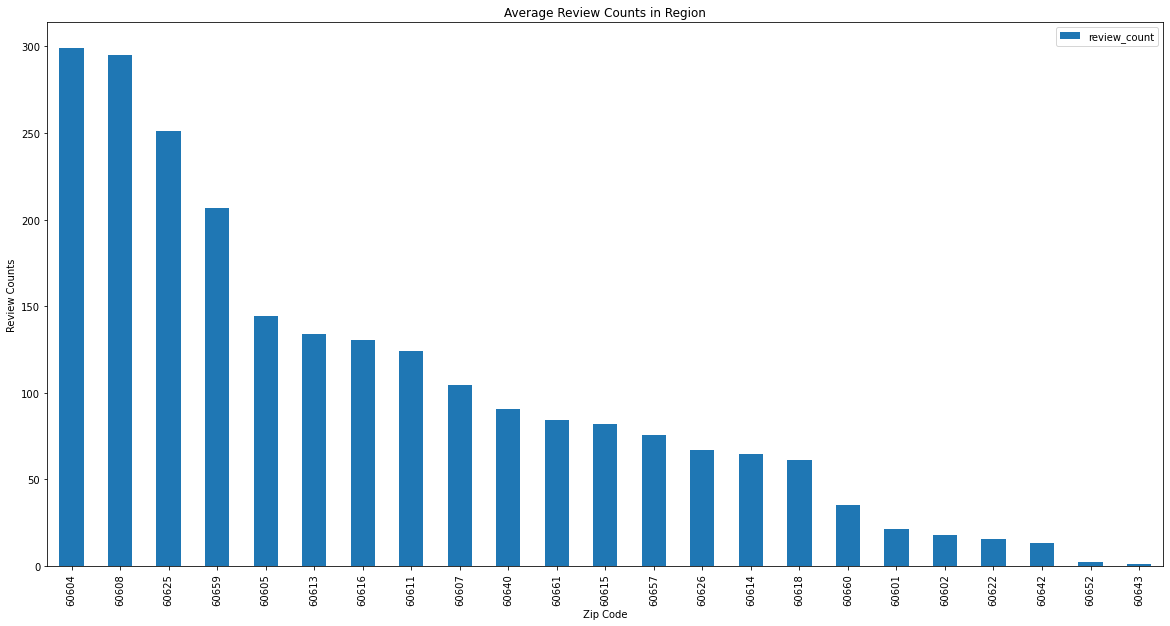

In [12]:
print(min(df.review_count), max(df.review_count), df.review_count.mean(), df.review_count.median())
df.sort_values(by='review_count', ascending=False).plot('zipcode', 'review_count', kind='bar', figsize=(20, 10), xlabel='Zip Code', ylabel='Review Counts', title='Average Review Counts in Region')

As for price, most shops in each region also have similar prices.

1.0 2.0 1.5033943183177028 1.5696202531645569


<AxesSubplot:title={'center':'Average Price in Region'}, xlabel='Zip Code', ylabel='Price'>

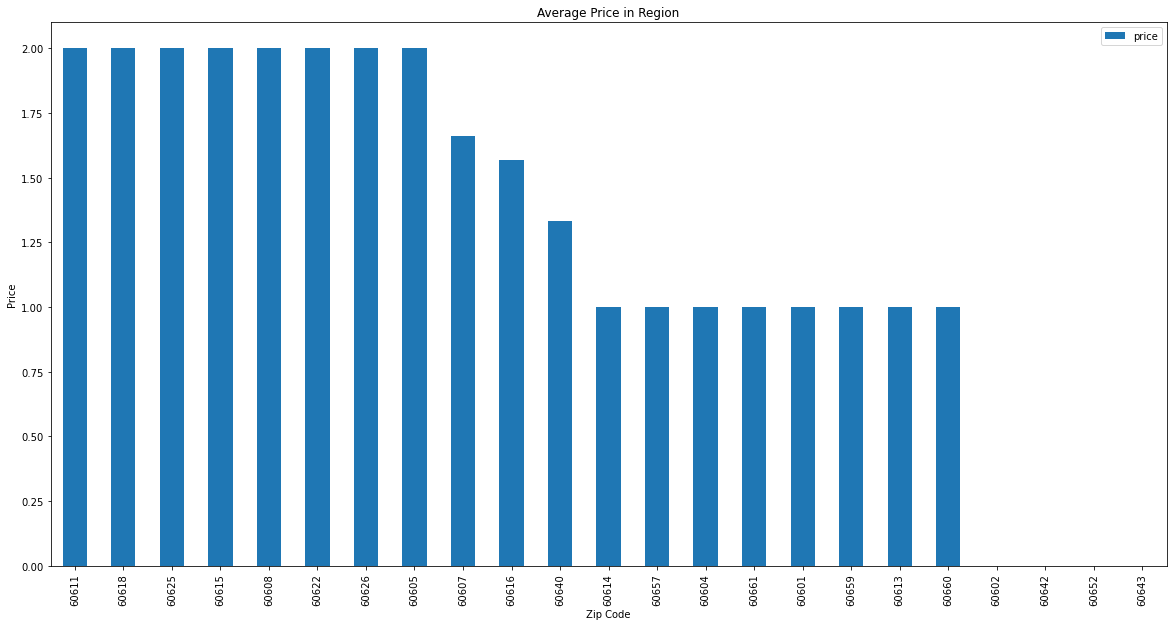

In [13]:
print(min(df.price), max(df.price), df.price.mean(), df.price.median())
df.sort_values(by='price', ascending=False).plot('zipcode', 'price', kind='bar', figsize=(20, 10), xlabel='Zip Code', ylabel='Price', title='Average Price in Region')

#### Correlation between population and bubble tea shops
3. How are population characteristics associated with number of bubble tea shops in a region?
4. Is having larger Asian populations in area associated with higher or lower rating?
5. Would review count show any correlation with population demographics?
6. Which population group would be strongly associated with the average price of bubble tea shops in corresponding region?

In [14]:
# population to total number of shops
df.corrwith(df['counts'])

zipcode                              -0.256328
counts                                1.000000
rating                                0.062441
review_count                          0.042067
price                                 0.040451
Population - Total                    0.028780
Population - Age 0-17                -0.151879
Population - Age 18-29                0.100026
Population - Age 30-39               -0.094672
Population - Age 40-49                0.050073
Population - Age 50-59                0.064007
Population - Age 60-69                0.077699
Population - Age 70-79                0.074106
Population - Age 80+                  0.117048
Population - Age 5-11                -0.148816
Population - Age 12-17               -0.039864
Population - Age 5+                   0.285839
Population - Age 18+                  0.151879
Population - Age 65+                  0.121682
Population - Female                   0.091322
Population - Male                    -0.091322
Population - 

Asian population is positively associated with number of bubble tea shops in a region.

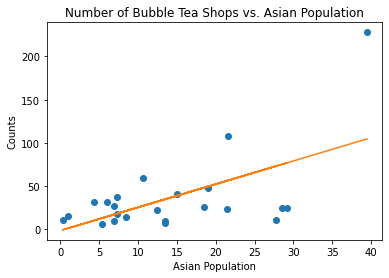

In [15]:
plt.plot(df['Population - Asian Non-Latinx'], df['counts'], 'o')
plt.xlabel('Asian Population')
plt.ylabel('Counts')
plt.title('Number of Bubble Tea Shops vs. Asian Population')
m, b = np.polyfit(df['Population - Asian Non-Latinx'], df['counts'], 1)
plt.plot(df['Population - Asian Non-Latinx'], m*df['Population - Asian Non-Latinx']+b)

Number of bubble tea shops in a region is positively associated with percentage of Asian non-Latinx population. It is as expected because bubble tea originated from Asia, and regions where more Asians reside would have more Asian people running or going to bubble tea shops. 

In [16]:
# population to average ratings
df.corrwith(df['rating'])

zipcode                              -0.002960
counts                                0.062441
rating                                1.000000
review_count                         -0.034707
price                                -0.121380
Population - Total                    0.106397
Population - Age 0-17                 0.057165
Population - Age 18-29               -0.109853
Population - Age 30-39                0.107820
Population - Age 40-49                0.059453
Population - Age 50-59               -0.066473
Population - Age 60-69               -0.038773
Population - Age 70-79               -0.090319
Population - Age 80+                  0.047436
Population - Age 5-11                 0.049720
Population - Age 12-17               -0.008285
Population - Age 5+                  -0.143582
Population - Age 18+                 -0.057165
Population - Age 65+                 -0.033899
Population - Female                  -0.150961
Population - Male                     0.150961
Population - 

Surprisingly, average rating is not strongly associated with any of the population characteristics. Rating is weakly correlated with other race population in positive direction, and Latinx population but in negative direction. 

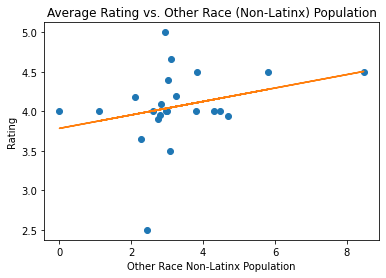

In [17]:
plt.plot(df['Population - Other Race Non-Latinx'], df['rating'], 'o')
plt.xlabel('Other Race Non-Latinx Population')
plt.ylabel('Rating')
plt.title('Average Rating vs. Other Race (Non-Latinx) Population')
m, b = np.polyfit(df['Population - Other Race Non-Latinx'], df['rating'], 1)
plt.plot(df['Population - Other Race Non-Latinx'], m*df['Population - Other Race Non-Latinx']+b)

Rating seems to have little difference with respect to different populations. It worths exploring whether other factors would have stronger correlation with average ratings of bubble tea shops, such as customers' income and product variabilities. 

In [18]:
# population to average review counts
df.corrwith(df['review_count'])

zipcode                              -0.264296
counts                                0.042067
rating                               -0.034707
review_count                          1.000000
price                                 0.085832
Population - Total                    0.127930
Population - Age 0-17                -0.036613
Population - Age 18-29                0.138750
Population - Age 30-39               -0.191825
Population - Age 40-49               -0.302673
Population - Age 50-59                0.149430
Population - Age 60-69                0.203456
Population - Age 70-79                0.126724
Population - Age 80+                 -0.062718
Population - Age 5-11                -0.063887
Population - Age 12-17                0.070467
Population - Age 5+                   0.141656
Population - Age 18+                  0.036613
Population - Age 65+                  0.037836
Population - Female                  -0.070717
Population - Male                     0.070717
Population - 

Review count does not show a strong correlation with population characteristics as well. Asian population is positively associated with average review counts of bubble tea shops, however, this does not necessarily indicate that Asian customers would more likely to leave reviews for bubble tea shops. It could also be that Asian shop runners would pay more attention and respond to online Yelp reviews. 

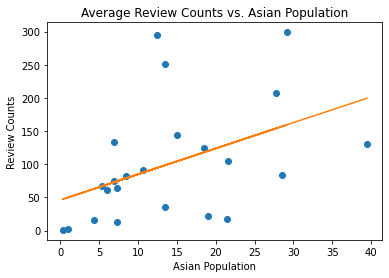

In [19]:
plt.plot(df['Population - Asian Non-Latinx'], df['review_count'], 'o')
plt.xlabel('Asian Population')
plt.ylabel('Review Counts')
plt.title('Average Review Counts vs. Asian Population')
m, b = np.polyfit(df['Population - Asian Non-Latinx'], df['review_count'], 1)
plt.plot(df['Population - Asian Non-Latinx'], m*df['Population - Asian Non-Latinx']+b)

Review count may not be a direct factor that reflects bubble tea shops' situation in a region, but the content of reviews, reasons and effects of large numbers of reviews can provide more information and show the relationship between bubble tea shops and local populations. 

In [20]:
# population to average price
df.corrwith(df['price'])

zipcode                              -0.428480
counts                                0.040451
rating                               -0.121380
review_count                          0.085832
price                                 1.000000
Population - Total                    0.326307
Population - Age 0-17                 0.260394
Population - Age 18-29               -0.388393
Population - Age 30-39               -0.064442
Population - Age 40-49                0.194795
Population - Age 50-59                0.223764
Population - Age 60-69                0.022137
Population - Age 70-79                0.098737
Population - Age 80+                  0.256405
Population - Age 5-11                 0.273826
Population - Age 12-17                0.218952
Population - Age 5+                  -0.232788
Population - Age 18+                 -0.260394
Population - Age 65+                  0.170257
Population - Female                   0.094109
Population - Male                    -0.094109
Population - 

Although no population characteristic is strongly associated with average price of bubble tea shops, but interestingly, several age and race groups are correlated with the price factor. White population is negatively correlated with price, but Latinx population is having a positive association with average price. An obvious negative correlation is also found in people age 18-29. 

Note that the price data was in concrete form instead of continuous form, which made average prices also close to integers rather than continuous values, and the approximations of product price in each bubble tea shop are not accurate. In the following scatter plots, I could not sketch the fitted line because the points are sitting close to integer numbers.  

Text(0.5, 1.0, 'Average Price vs. White Population')

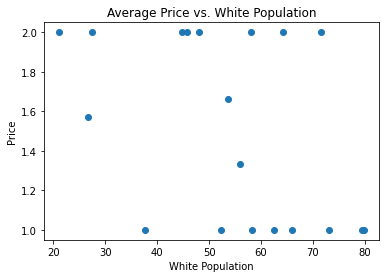

In [21]:
plt.plot(df['Population - White Non-Latinx'], df['price'], 'o')
plt.xlabel('White Population')
plt.ylabel('Price')
plt.title('Average Price vs. White Population')

Text(0.5, 1.0, 'Average Price vs. Latinx Population')

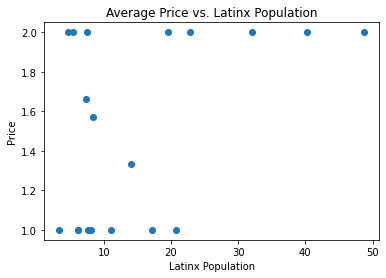

In [22]:
plt.plot(df['Population - Latinx'], df['price'], 'o')
plt.xlabel('Latinx Population')
plt.ylabel('Price')
plt.title('Average Price vs. Latinx Population')

Unlike my expectation, price does not reflect a strong correlation with populations. Different demographic groups may have different consuming behaviors, and the patterns can be found through their reactions to product price. For example, people in age group 18-29 years old may be more careful in spending money, and that can influence the market price of entertainment in the surrounded area. 

Overall, this project has navigated the statistics of bubble tea shops in Chicago area, and the relationship between local populations and bubble tea shops. Although not all findings in this project are significant as expected, they could be the starting point for future research to include more information and carefully examine other correlations between small businesses and local neighborhoods.